In [ ]:
#Extract Covid Cohen

import numpy as np
import cv2
import pandas as pd
from glob import glob
import os


img_path = 'D:\\University\\Master\\Term 3\\Computer Vision\\HWs\\Project I\\Dataset\\images\*'
csv_path = 'D:\\University\\Master\\Term 3\\Computer Vision\\HWs\\Project I\\Dataset\\metadata.csv'
save_path = 'D:\\University\\Master\\Term 3\\Computer Vision\\HWs\\Project I\\COVID-19 dataset\\Covid'
save_path2 = 'D:\\University\\Master\\Term 3\\Computer Vision\\HWs\\Project I\\COVID-19 dataset\\Normal'

path_img = sorted(glob(img_path))
csv_file = pd.read_csv(csv_path)
flag = 'COVID-19'

for i in range(csv_file.shape[0]):
    
    finding = csv_file['finding'][i]
    if flag in finding:
        filename = os.path.splitext(csv_file['filename'][i])[0]
        for img_path in path_img:
            img_name = os.path.splitext(os.path.basename(img_path))[0]
            if img_name == filename:
                img = cv2.imread(img_path)
                cv2.imwrite(save_path + '\Covid_'+os.path.basename(img_path), img)
    else: 
        filename = os.path.splitext(csv_file['filename'][i])[0]
        for img_path in path_img:
            img_name = os.path.splitext(os.path.basename(img_path))[0]
            if img_name == filename:
                img = cv2.imread(img_path)
                cv2.imwrite(save_path2 + '\\Normal_'+os.path.basename(img_path), img)




In [1]:
import os
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm

def calculate_overall_mean_std(data_path, subset_ratio=0.7, target_size=(224, 224)):
    """
    Calculate the overall mean and standard deviation for 70% of the images from both classes (Covid and Normal).
    
    Args:
    data_path (str): Path to the dataset containing 'Covid' and 'Normal' subfolders.
    subset_ratio (float): Proportion of images to use for calculating statistics (default is 70%).
    target_size (tuple): Target size for resizing images.
    
    Returns:
    - overall_mean (list): Overall mean values for (R, G, B).
    - overall_std (list): Overall standard deviation values for (R, G, B).
    """
    image_paths = []

    # Collect image paths for both classes (Covid and Normal)
    for root, subfolders, filenames in os.walk(data_path):
        for k in subfolders:
            if k == 'Covid' or k == 'Normal':  # Collect paths for both 'Covid' and 'Normal'
                filepath = os.path.join(root, k, "*")
                paths = sorted(glob(filepath))
                image_paths.extend(paths)

    # Shuffle the image paths to ensure randomness
    np.random.shuffle(image_paths)
    
    # Select 70% of the images for training
    train_paths = image_paths[:int(len(image_paths) * subset_ratio)]

    # Initialize variables to calculate mean and std
    pixel_sum = np.zeros(3)
    pixel_sq_sum = np.zeros(3)
    num_pixels = 0

    # Iterate over the selected 70% images
    for img_path in tqdm(train_paths, desc="Calculating Overall Mean and Std"):
        try:
            # Read the image
            img = cv2.imread(img_path)
            if img is None:
                print(f"Could not read image: {img_path}")
                continue

            # Resize the image
            img_resized = cv2.resize(img, target_size)

            # Normalize to [0, 1]
            img_resized = img_resized / 255.0  # Scaling to [0, 1]

            # Accumulate pixel sums and squared sums
            pixel_sum += np.sum(img_resized, axis=(0, 1))
            pixel_sq_sum += np.sum(img_resized**2, axis=(0, 1))
            num_pixels += img_resized.shape[0] * img_resized.shape[1]  # Total pixels per image

        except Exception as e:
            print(f"Error processing {img_path}: {e}")

    # Calculate overall mean and std
    overall_mean = pixel_sum / num_pixels
    overall_std = np.sqrt((pixel_sq_sum / num_pixels) - (overall_mean**2))

    return overall_mean.tolist(), overall_std.tolist()

# Example usage
data_path = r"D:\University\Master\Term 3\Computer Vision\HWs\Project I\Attempt 2\MachineVision Dataset\Dataset"
overall_mean, overall_std = calculate_overall_mean_std(data_path)

print(f"Overall Mean: {overall_mean}")
print(f"Overall Std: {overall_std}")


Calculating Overall Mean and Std: 100%|██████████| 2100/2100 [00:59<00:00, 35.20it/s]

Overall Mean: [0.5113713164952965, 0.5111083020633332, 0.5110829029900134]
Overall Std: [0.2556174130529046, 0.2555650771697803, 0.2555635740709926]


In [2]:
import numpy as np
import cv2
import os
from glob import glob
from tqdm import tqdm
import torch
import torchvision.transforms as transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def create_dataset_folders(data_path, created_path, split_ratio=0.7, num_class=2, image_size=224):
    """
    Separate image dataset into train, validation, and test sets with preprocessing.
    
    Args:
    data_path (str): Path to the original dataset
    created_path (str): Path where separated dataset will be created
    split_ratio (float): Proportion of data to be used for training
    num_class (int): Number of classes in the dataset
    image_size (int): Size to resize images to
    """
    # Create transforms for preprocessing
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5114, 0.5111, 0.5111], std=[0.2556, 0.2556, 0.2556])
    ])
    
    for root, subfolders, filenames in os.walk(data_path):
        if len(subfolders) == num_class:
            for k in subfolders:
                # Create output directories if they don't exist
                os.makedirs(os.path.join(created_path, "Train", k), exist_ok=True)
                os.makedirs(os.path.join(created_path, "Valid", k), exist_ok=True)
                os.makedirs(os.path.join(created_path, "Test", k), exist_ok=True)
                
                # Get all image paths for this class
                filepath = os.path.join(root, k, "*")
                paths = sorted(glob(filepath))
                
                # Calculate split indices
                total_images = len(paths)
                train_count = int(total_images * 0.7)  # 70% train
                valid_count = int(total_images * 0.2)  # 20% validation
                test_count = total_images - train_count - valid_count  # 10% test
                
                # Shuffle paths to ensure random distribution
                np.random.seed(42)  # for reproducibility
                np.random.shuffle(paths)
                
                # Split and save images
                for i, img_path in tqdm(enumerate(paths), total=total_images, desc=f"Processing {k} class"):
                    try:
                        # Read image
                        img = cv2.imread(img_path)
                        
                        # Check if image is loaded successfully
                        if img is None:
                            print(f"Could not read image: {img_path}")
                            continue
                        
                        # Convert BGR to RGB (OpenCV reads in BGR)
                        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        
                        # Apply preprocessing
                        img_preprocessed = transform(img_rgb)
                        
                        # Convert tensor back to numpy for saving
                        img_to_save = (img_preprocessed.numpy() * 255).astype(np.uint8)
                        img_to_save = np.transpose(img_to_save, (1, 2, 0))
                        
                        # Generate unique filename
                        class_name = os.path.basename(img_path)
                        unique_filename = f"{os.path.splitext(class_name)[0]}_{i}.jpg"
                        
                        if i < train_count:
                            # Train set
                            cv2.imwrite(os.path.join(created_path, "Train", k, unique_filename), 
                                        cv2.cvtColor(img_to_save, cv2.COLOR_RGB2BGR))
                        elif i < train_count + valid_count:
                            # Validation set
                            cv2.imwrite(os.path.join(created_path, "Valid", k, unique_filename), 
                                        cv2.cvtColor(img_to_save, cv2.COLOR_RGB2BGR))
                        else:
                            # Test set
                            cv2.imwrite(os.path.join(created_path, "Test", k, unique_filename), 
                                        cv2.cvtColor(img_to_save, cv2.COLOR_RGB2BGR))
                    
                    except Exception as e:
                        print(f"Error processing {img_path}: {e}")

def print_dataset_stats(created_path):
    """
    Print statistics about the created dataset
    
    Args:
    created_path (str): Path where the dataset was created
    """
    print("\nDataset Statistics:")
    for split in ['Train', 'Valid', 'Test']:
        print(f"\n{split} Set:")
        for class_dir in os.listdir(os.path.join(created_path, split)):
            class_path = os.path.join(created_path, split, class_dir)
            num_images = len(os.listdir(class_path))
            print(f"{class_dir}: {num_images} images")

def main():
    # Paths
    data_path = r"D:\University\Master\Term 3\Computer Vision\HWs\Project I\Attempt 2\MachineVision Dataset\Dataset"
    create_path = r"D:\University\Master\Term 3\Computer Vision\HWs\Project I\Improvement\MachineVision Dataset\Final dataset seperated"
    
    # Ensure created path exists
    os.makedirs(create_path, exist_ok=True)
    
    # Create dataset
    create_dataset_folders(
        data_path=data_path, 
        created_path=create_path, 
        split_ratio=0.7, 
        num_class=2,  # Adjust based on your dataset
        image_size=224
    )
    
    # Print dataset statistics
    print_dataset_stats(create_path)

if __name__ == '__main__':
    main()

Processing Normal class: 100%|██████████| 1500/1500 [01:06<00:00, 22.49it/s]


Dataset Statistics:

Train Set:
Covid: 1050 images
Normal: 1050 images

Valid Set:
Covid: 300 images
Normal: 300 images

Test Set:
Covid: 150 images
Normal: 150 images


Found 1680 images belonging to 2 classes.
Found 420 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Epoch 1/50
112/112 [==============================] - ETA: 0s - loss: 0.6983 - accuracy: 0.5077
Epoch 1: val_loss improved from inf to 0.69106, saving model to D:\University\Master\Term 3\Computer Vision\HWs\Project I\Improvement\cnn_model_improved.h5
112/112 [==============================] - 46s 304ms/step - loss: 0.6983 - accuracy: 0.5077 - val_loss: 0.6911 - val_accuracy: 0.5929
Epoch 2/50
112/112 [==============================] - ETA: 0s - loss: 0.6903 - accuracy: 0.5274
Epoch 2: val_loss improved from 0.69106 to 0.68524, saving model to D:\University\Master\Term 3\Computer Vision\HWs\Project I\Improvement\cnn_model_improved.h5
112/112 [==============================] - 20s 178ms/step - loss: 0.6903 - accuracy: 0.5274 - val_loss: 0.6852 - val_accuracy: 0.6333
Epoch 3/50
112/112 [==============================] - ETA: 0s - loss: 0.6677 - accuracy: 0.6095
Epoc

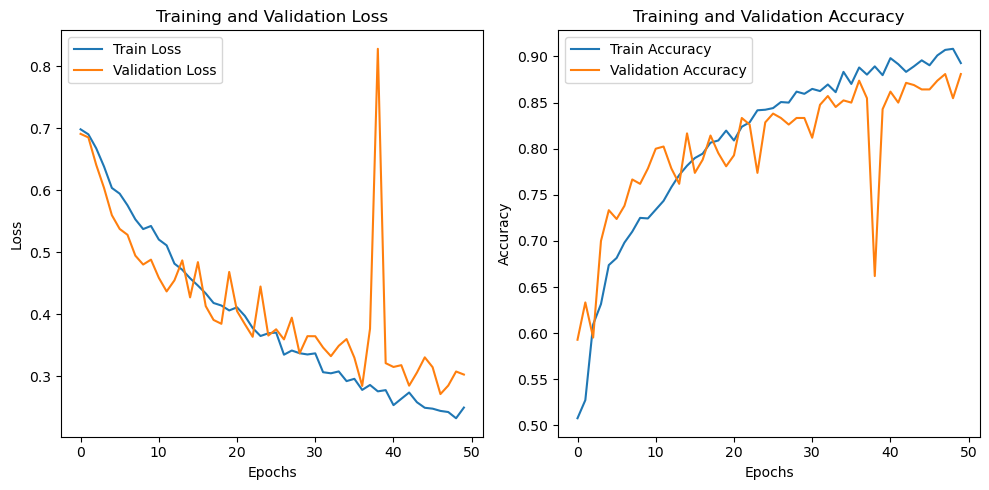

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

# Ensure reproducibility
tf.random.set_seed(42)
np.random.seed(42)

def create_cnn_model(input_shape=(224, 224, 3)):
    model = models.Sequential([
        # Layer 1: Conv2D: to extract spatial features
        layers.Conv2D(32, (3, 3), strides=1, padding='valid', activation='relu', input_shape=input_shape),
        
        # Layer 2: Conv2D: to extract spatial features
        layers.Conv2D(128, (3, 3), strides=1, padding='valid', activation='relu'),
        
        # Layer 3: MaxPooling: to reduce spatial dimensions
        layers.MaxPooling2D((2, 2), strides=2),
        
        # Layer 4: Dropout
        layers.Dropout(0.25),
        
        # Layer 5: Conv2D: to extract spatial features
        layers.Conv2D(64, (3, 3), strides=1, padding='valid', activation='relu'),
        
        # Layer 6: MaxPooling: to reduce spatial dimensions
        layers.MaxPooling2D((2, 2), strides=2),
        
        # Layer 7: Dropout
        layers.Dropout(0.25),
        
        # Layer 8: Conv2D: to extract spatial features
        layers.Conv2D(128, (3, 3), strides=1, padding='valid', activation='relu'),
        
        # Layer 9: MaxPooling: to reduce spatial dimensions
        layers.MaxPooling2D((2, 2), strides=2),
        
        # Layer 10: Dropout
        layers.Dropout(0.25),
        
        # Layer 11: Conv2D: to extract spatial features
        layers.Conv2D(512, (3, 3), strides=1, padding='valid', activation='relu'),
        
        # Layer 12: MaxPooling: to reduce spatial dimensions
        layers.MaxPooling2D((2, 2), strides=2),
        
        # Layer 13: Dropout
        layers.Dropout(0.25),
        
        # Layer 14: Conv2D: to extract spatial features
        layers.Conv2D(512, (3, 3), strides=1, padding='valid', activation='relu'),
        
        # Layer 15: MaxPooling: to reduce spatial dimensions
        layers.MaxPooling2D((2, 2), strides=2),
        
        # Layer 16: Dropout
        layers.Dropout(0.25),
        
        # Layer 17: Flatten
        layers.Flatten(),
        
        # Layer 18: Fully Connected Layer
        layers.Dense(64, activation='relu'),
        
        # Layer 19: Dropout
        layers.Dropout(0.25),
        
        # Layer 20: Output Layer
        layers.Dense(2, activation='sigmoid')
    ])
    
    return model

def main():
    # Configurations
    train_dir = r'D:\University\Master\Term 3\Computer Vision\HWs\Project I\Improvement\MachineVision Dataset\Final dataset seperated\Train'
    valid_dir = r'D:\University\Master\Term 3\Computer Vision\HWs\Project I\Improvement\MachineVision Dataset\Final dataset seperated\Valid'
    test_dir = r'D:\University\Master\Term 3\Computer Vision\HWs\Project I\Improvement\MachineVision Dataset\Final dataset seperated\Test'
    save_path = r'D:\University\Master\Term 3\Computer Vision\HWs\Project I\Improvement\cnn_model_improved.h5'
    Train_flag = True

    # Data Augmentation and Preprocessing
    train_datagen = ImageDataGenerator(
        rescale=1./255, 
        rotation_range=20,  # X-ray images don’t require aggressive augmentation
        width_shift_range=0.2,  
        height_shift_range=0.2,
        horizontal_flip=True, # Avoid unrealistic augmentations for medical data
        validation_split=0.2
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    # Load and Prepare Datasets
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=15,
        class_mode='categorical',
        subset='training'
    )

    valid_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=15,
        class_mode='categorical',
        subset='validation'
    )

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=460,
        class_mode='categorical',
        shuffle=False
    )

    if Train_flag:
        # Create and Compile Model
        model = create_cnn_model()
        model.compile(
            optimizer=optimizers.RMSprop(learning_rate=0.0001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        # Model Checkpoint
        checkpoint = ModelCheckpoint(
            save_path, 
            monitor='val_loss', 
            save_best_only=True, 
            mode='min', 
            verbose=1
        )

        # Training
        history = model.fit(
            train_generator,
            steps_per_epoch=train_generator.samples // train_generator.batch_size,
            validation_data=valid_generator,
            validation_steps=valid_generator.samples // valid_generator.batch_size,
            epochs=50,
            callbacks=[checkpoint]
        )

        # Plot Training History
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title('Training and Validation Loss')
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.title('Training and Validation Accuracy')
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.tight_layout()
        plt.show()

    else:
        # Testing Phase
        model = tf.keras.models.load_model(save_path)

        # Evaluate on Test Data
        test_loss, test_accuracy = model.evaluate(test_generator)
        
        # Predictions
        predictions = model.predict(test_generator)
        y_pred = np.argmax(predictions, axis=1)
        y_true = test_generator.classes

        # Confusion Matrix
        from sklearn.metrics import confusion_matrix, classification_report
        cm = confusion_matrix(y_true, y_pred)
        
        # Plot Confusion Matrix
        import seaborn as sns
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Normal', 'Covid'], 
                    yticklabels=['Normal', 'Covid'])
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        # Classification Report
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, target_names=['Normal', 'Covid']))

        # Additional Metrics
        from sklearn.metrics import precision_score, recall_score, f1_score
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')

        print(f"\nTest Loss: {test_loss:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-score: {f1:.4f}")

if __name__ == '__main__':
    main()